In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [3]:
df_music = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv')

In [4]:
df_music.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount
count,1000.000000,1000,1000,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN
top,NaN,The Beatles,Wipe Out,NaN,NaN
freq,NaN,23,2,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,7.899716e+06
std,28.922799,NaN,NaN,2.875111,1.992259e+07
min,1.000000,NaN,NaN,1960.000000,1.554000e+03
25%,25.750000,NaN,NaN,1962.000000,2.437070e+05
50%,50.500000,NaN,NaN,1964.500000,8.641245e+05
75%,76.000000,NaN,NaN,1967.000000,4.963935e+06


# 1 Visualization

## 1.1 Heat Map: Correlation

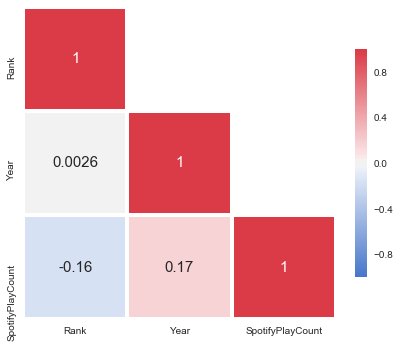

In [5]:
sns.set(style="white")
corr = df_music.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

## 1.2 Histogram: Play Count (Original)

In [6]:
df_playCount = df_music.SpotifyPlayCount

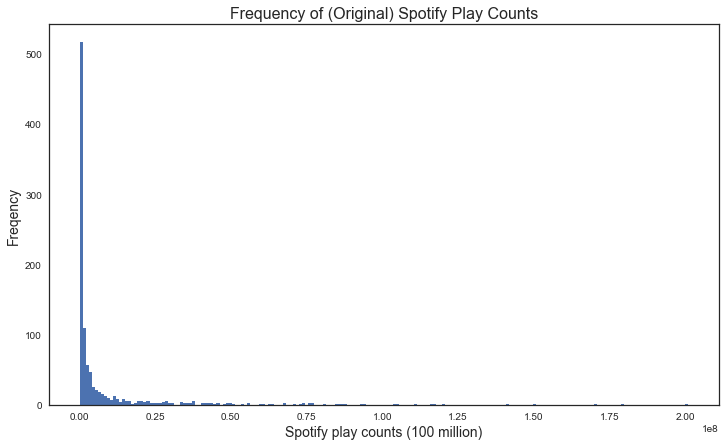

In [7]:
ax = df_playCount.plot.hist(bins=200, figsize=(12,7))
ax.set_title('Frequency of (Original) Spotify Play Counts',fontsize=16)
ax.set_xlabel("Spotify play counts (100 million)", fontsize=14)
ax.set_ylabel("Freqency", fontsize=14)

In [8]:
df_playCount2 = df_music[df_music.SpotifyPlayCount < 1000000]

In [9]:
df_playCount2.shape

(513, 5)

The play count distribution is largely **skewed**. The biggest play count is over 200 million, while 513 out of 1000 songs have a play count lower than 1 million.

## 1.3 Histogram: Play Count (Logarithm)

In [10]:
df_playCount3 = np.log(df_music.SpotifyPlayCount)

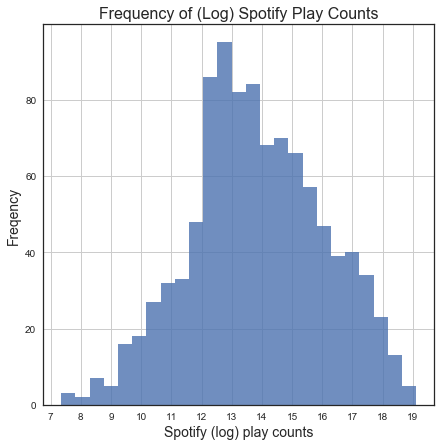

In [11]:
min_count = math.floor(df_playCount3.min())
max_count = math.ceil(df_playCount3.max())
ax = df_playCount3.plot.hist(bins=25, figsize=(7,7), alpha=0.8)
ax.set_xticks(np.arange(min_count, max_count))
ax.set_title('Frequency of (Log) Spotify Play Counts',fontsize=16)
ax.set_xlabel("Spotify (log) play counts", fontsize=14)
ax.set_ylabel("Freqency", fontsize=14)
ax.grid()

After logarithm, the distribution looks much like **bell shape**. It makes sense to change our original target to the log-target.

## 1.4 Heat Map: Correlation with Log Target

The following correlation heat map with **log** target is **better** than the correlation heat map with **original** target. A higher correlation implys that we are more likely to build a model with lower error.

In [12]:
df_music_clean = df_music.copy()
df_music_clean.SpotifyPlayCount = np.log(df_music_clean.SpotifyPlayCount)
df_music_clean.rename(columns={'SpotifyPlayCount':'LogPlayCount'}, inplace=True)

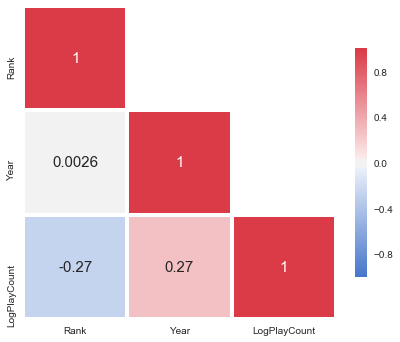

In [13]:
sns.set(style="white")
corr = df_music_clean.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})


## 1.5 Bar: Frequency of Artists

The frequency of each artist. The Beatles has the highest frequency with 23 times.

In [14]:
ser_artists = df_music_clean.Artist   # 1000 artists
arr_artists = ser_artists.unique()    # 551 unique artists

Use a dictionary to count the frequency of each unique artist.

In [15]:
dic_artist_count = {} 

In [16]:
for i in arr_artists:
    dic_artist_count[i] = 0
    
for i in ser_artists:
    dic_artist_count[i] = dic_artist_count[i] + 1

In [17]:
frequency = dic_artist_count.values()
list_frequency = list(frequency)  
ser_frequency = pd.Series(list_frequency)

Use a dictionary to count the frequency of the **frequency of each unique artist**.

In [18]:
dic_frequency_count = {}

In [19]:
arr_frequency = ser_frequency.unique()

for i in arr_frequency:
    dic_frequency_count[i] = 0
    
for i in ser_frequency:
    dic_frequency_count[i] = dic_frequency_count[i] + 1

There are 373 artists who only show up once in the charts. There is one artist who show up 23 times, which is The Beatles.

In [20]:
dic_frequency_count

{1: 369,
 2: 80,
 3: 38,
 4: 19,
 5: 17,
 6: 9,
 7: 7,
 8: 2,
 9: 1,
 10: 1,
 11: 2,
 13: 1,
 23: 1}

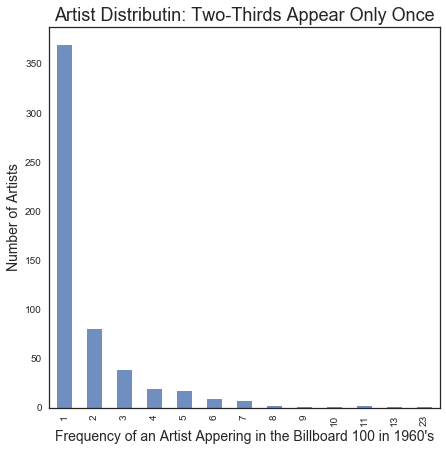

In [21]:
ser_frequency_count = pd.Series(dic_frequency_count)
ax = ser_frequency_count.plot.bar(figsize=(7,7), alpha=0.8)
ax.set_title('Artist Distributin: Two-Thirds Appear Only Once', fontsize=18)
ax.set_xlabel('Frequency of an Artist Appering in the Billboard 100 in 1960\'s', fontsize=14)
ax.set_ylabel('Number of Artists', fontsize=14)

# 2 Baseline Model

## 2.1 Z-score the Features

In [22]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [23]:
z_score_norm(df_music_clean, feature_list=['Rank', 'Year'])

In [24]:
df_music_clean.head()

,Rank,Artist,Title,Year,LogPlayCount
0,-1.713078,Percy Faith,"Theme From ""A Summer Place""",-1.565505,15.425179
1,-1.678503,Jim Reeves,He'll Have To Go,-1.565505,15.291952
2,-1.643928,The Everly Brothers,Cathy's Clown,-1.565505,15.246003
3,-1.609353,Johnny Preston,Running Bear,-1.565505,14.183606
4,-1.574778,Mark Dinning,Teen Angel,-1.565505,12.986026


## 2.2 The Linear Regression

Extract target and features

In [25]:
target = df_music_clean.loc[:,'LogPlayCount']
feature = df_music_clean.loc[:,['Rank', 'Year']]

In [26]:
print(feature.shape)
print(target.shape)

(1000, 2)
(1000,)


In [27]:
lr = linear_model.LinearRegression()

# 3 Single-command Evaluation

![evaluation](../figure/evaluation.png)

A single-command program that runs our model on the evaluation data, and produce plots/reports on its effectiveness is very important.

In [28]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5) 

In [29]:
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the absolute error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    aboerr = pred - target   # aboerr is a Series
    min_err = aboerr.min()
    max_err = aboerr.max()
    ax = aboerr.plot.hist(bins=20, figsize=(7,7), alpha=0.8)
    ax.set_xticks(np.arange(math.floor(min_err),math.ceil(max_err)))
    ax.set_title('%s - Absolute Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Absolute Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()

In [30]:
def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    plt.scatter(target, pred, edgecolors=(0, 0, 0), s=20)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()

In [31]:
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()

In [32]:
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

This is the plots/reports of LinearRegression


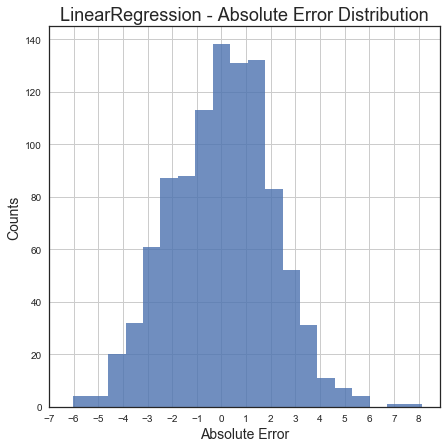

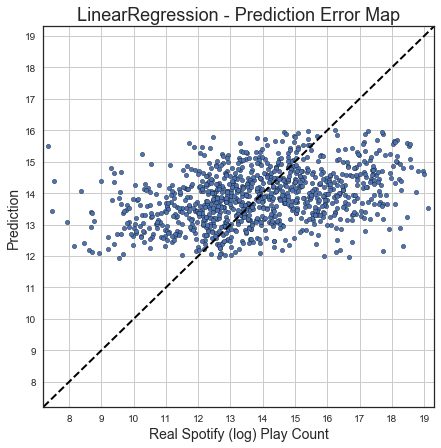

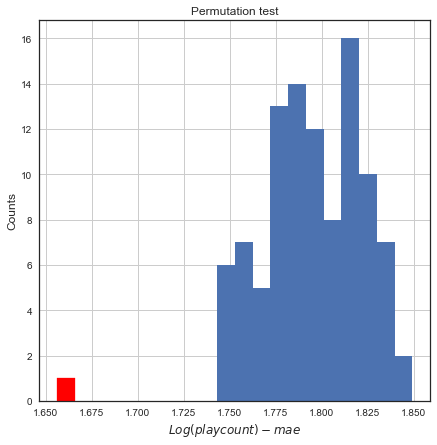

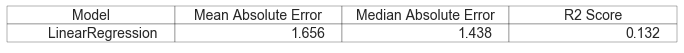

In [33]:
evaluation(lr, feature, target)